## Utils


In [1]:
import pandas as pd
import glob
import os
import re
from IPython.display import display
from typing import Dict, List, Tuple

parent_dir = os.path.dirname(os.getcwd())
# date = "10.28"
date_in_filename = os.path.basename(parent_dir)
date=date_in_filename.split("_")[0]

save_dir = os.path.join(parent_dir, "tex")
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

data_dir = os.path.join(parent_dir, "processed_data")



# Get session id list from data directory
session_id_list = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        session_id=file_path.split('clean_')[1].rstrip('.csv')
        session_id_list.append(session_id)


 

In [2]:

STAGE_ORDER = [
    "Data Processor",
    "Model Converter",
    "Sketch Generator",
    "PySketch Generator",
    "TPUSketch Generator",
]
STAGE_ABBR = {
    "Data Processor": "DP",
    "Model Converter": "MC",
    "Sketch Generator": "SG",
    "PySketch Generator": "PSG",
    "TPUSketch Generator": "TPUSG",
}
TASK_COLORS = {
    "Model Converter": "blue",
    "Data Processor": "green",
    "Sketch Generator": "purple",
    "PySketch Generator": "red",
    "TPUSketch Generator": "orange",
}
STAT_LABELS = {"mean": "Ave", "median": "Med", "max": "Max", "min": "Min"}


def get_model_name(tags: str) -> str:
    known_values = {
        "benchmark",
        "experiment",
        "data_processor",
        "model_converter",
        "sketch_generator",
        "py_sketch_generator",
        "pysketch_generator",
        "tpu_ketch_generator",
    }
    cleaned_tags = [
        tag.strip()
        for tag in (
            tags.replace("{", "")
            .replace("}", "")
            .replace("[", "")
            .replace("]", "")
            .replace("'", "")
            .replace('"', "")
        ).split(",")
    ]
    return next((tag for tag in cleaned_tags if tag and tag not in known_values), None)


def process_batch_csvs(data_dir: str) -> Tuple[pd.DataFrame, Dict[str, Dict[str, str]]]:
    processor_names = {
        "dp": {"full_name": "Data Processor", "short_name": "DP", "processor_type": "data_processor"},
        "mc": {"full_name": "Model Converter", "short_name": "MC", "processor_type": "model_converter"},
        "sg": {"full_name": "Sketch Generator", "short_name": "SG", "processor_type": "sketch_generator"},
        "psg": {"full_name": "PySketch Generator", "short_name": "PSG", "processor_type": "py_sketch_generator"},
        "tpusg": {"full_name": "TPUSketch Generator", "short_name": "TPUSG", "processor_type": "tpu_sketch_generator"},
    }

    dfs: List[pd.DataFrame] = []
    batch_info: Dict[str, Dict[str, str]] = {}
    pattern = r"clean_(.+?)_([a-z]+)_batch\.csv"

    for filename in os.listdir(data_dir):
        if not (filename.startswith("clean_") and filename.endswith("_batch.csv")):
            continue
        match = re.match(pattern, filename)
        if not match:
            continue
        processor_type = processor_names[match.group(2)]["processor_type"]
        batch_id = match.group(1) + "_" + match.group(2)
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path)
        df["processor_type"] = processor_type
        df["batch_id"] = batch_id
        dfs.append(df)
        batch_info[batch_id] = {
            "processor_type": processor_type,
            "full_name": processor_names[match.group(2)]["full_name"],
            "short_name": processor_names[match.group(2)]["short_name"],
            "model_name": get_model_name(df.iloc[0]["tags"]),
        }
    return (pd.concat(dfs, ignore_index=True), batch_info) if dfs else (pd.DataFrame(), {})


def extract_model_name(batch_info: Dict[str, Dict[str, str]]) -> str:
    model_name = next(iter(batch_info.values()))["model_name"]
    if model_name.startswith("phi4"):
        model_name = "phi4:14b"
    elif model_name.startswith("llama3.1"):
        model_name = "llama3.1:8b"
    return model_name



def parse_parameters(param_str: str) -> dict:
    if not param_str or param_str in ("{}", "null", "None"):
        return {}
    try:
        param_dict = {}
        items = param_str.strip("{} ").split(",")
        for item in items:
            if "top_p" in item:
                item = item.replace("top_p", "top-p")
            if ":" in item:
                key, value = item.split(":", 1)
                param_dict[key.strip(" '\"")] = value.strip(" '\"")
        return param_dict
    except Exception:
        return {}


def extract_unique_parameters(df: pd.DataFrame) -> list[dict]:
    param_sets = set()
    for param_str in df["parameters"]:
        params = parse_parameters(param_str)
        if params:
            param_sets.add(tuple(sorted(params.items())))
    return [dict(items) for items in param_sets]


def format_parameters_for_caption(df: pd.DataFrame) -> str:
    param_dicts = extract_unique_parameters(df)
    if not param_dicts:
        return "None"
    return "; ".join(", ".join(f"{k}={v}" for k, v in params.items()) for params in param_dicts)


def series_stats(series: pd.Series, stats=("mean", "median", "max", "min")) -> Dict[str, float]:
    funcs = {"mean": series.mean, "median": series.median, "max": series.max, "min": series.min}
    return {stat: funcs[stat]() for stat in stats}


def aggregate_by_processor(
    df: pd.DataFrame,
    batch_info: Dict[str, Dict[str, str]],
    columns: Dict[str, str],
    stats=("mean", "median", "max", "min"),
) -> Dict[str, Dict[str, Dict[str, float]]]:
    results: Dict[str, Dict[str, Dict[str, float]]] = {}
    for processor in df["processor_type"].unique():
        proc_df = df[df["processor_type"] == processor]
        sample_batch_id = proc_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = {key: series_stats(proc_df[col], stats) for key, col in columns.items()}
    return results


def stats_table(
    statistics: Dict[str, Dict[str, Dict[str, float]]],
    columns: List[tuple[str, str]],
    stats=("mean", "median", "max", "min"),
    fmt: Dict[str, callable] | None = None,
) -> pd.DataFrame:
    fmt = fmt or {}
    rows: List[Dict[str, float | str]] = []
    for stage in STAGE_ORDER:
        if stage not in statistics:
            continue
        row: Dict[str, float | str] = {"Stage": STAGE_ABBR[stage]}
        for key, label in columns:
            for stat in stats:
                val = statistics[stage][key][stat]
                if key in fmt:
                    val = fmt[key](val)
                row[f"{label} {STAT_LABELS.get(stat, stat.title())}"] = val
        rows.append(row)
    return pd.DataFrame(rows)


def iter_batches():
    """Yield combined_df, batch_info, model_name, model_params, batch_id, batch_uid per subdir."""
    for dir in sorted(os.listdir(data_dir)):
        combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
        if combined_df.empty or not batch_info:
            continue
        model_name = extract_model_name(batch_info)
        model_params = format_parameters_for_caption(combined_df).replace("_", "-")
        batch_id = next(iter(batch_info))
        batch_uid = batch_id.rsplit("_", 2)[-2]
        yield combined_df, batch_info, model_name, model_params, batch_id, batch_uid


def show_table(title: str, table: pd.DataFrame) -> None:
    print(f"\n{title}")
    display(table)

### Test Utils


In [3]:
import pprint

# Process the files
for dir in os.listdir(data_dir):
    print("\n" + "=" * 50)
    print(f"Directory: {os.path.join(data_dir, dir)}")
    print("=" * 50)

    combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
    print(f"Combined DataFrame shape: {combined_df.shape}")

    # Convert batch info to DataFrame for nice display
    batch_rows = []
    for batch_id, info in batch_info.items():
        batch_rows.append(
            {
                "Batch ID": batch_id,
                "Model": info["model_name"],
                "Processor": info["processor_type"],
                "Full Name": info["full_name"],
                "Short Name": info["short_name"],
            }
        )

    batch_df = pd.DataFrame(batch_rows)
    print("\nBatch Information:")
    parameters = format_parameters_for_caption(combined_df)

    print(f"Parameters: {parameters}")

    # print(batch_df.to_string(index=False))
    from tabulate import tabulate

    print(tabulate(batch_df, headers="keys", tablefmt="psql", showindex=False))
    print("\n")
    # print("####" * 8 + f"\nReturned combined_df:\n{combined_df.head()}")


# EXAMPLE PRINTING:

# Combined DataFrame shape: (60, 14)

# Batch Information:
# Batch 11281:
#   Processor Type: data_processor
#   Full Name: Data Processor
#   Short Name: DP
# Batch 11282:
#   Processor Type: model_converter
#   Full Name: Model Converter
#   Short Name: MC
# Batch 11283:
#   Processor Type: sketch_generator
#   Full Name: Sketch Generator
#   Short Name: SG


Directory: /home/han/Projects/benchmark-tinyml_llm-2026/langfuse_export/2026/02.08_abla-l1-gpt5/processed_data/gpt-5-2025-08-07_7aac
Combined DataFrame shape: (90, 17)

Batch Information:
Parameters: extra_body={}
+-----------------------------+------------------+----------------------+---------------------+--------------+
| Batch ID                    | Model            | Processor            | Full Name           | Short Name   |
|-----------------------------+------------------+----------------------+---------------------+--------------|
| gpt-5-2025-08-07_7aac_tpusg | gpt-5-2025-08-07 | tpu_sketch_generator | TPUSketch Generator | TPUSG        |
| gpt-5-2025-08-07_88d1_sg    | gpt-5-2025-08-07 | sketch_generator     | Sketch Generator    | SG           |
| gpt-5-2025-08-07_7aac_psg   | gpt-5-2025-08-07 | py_sketch_generator  | PySketch Generator  | PSG          |
+-----------------------------+------------------+----------------------+---------------------+--------------+




## 1. Token: overall, input, output; ave, med, max, min


In [4]:
TOKEN_COLUMNS = {
    "overall": "total_tokens",
    "input": "prompt_tokens",
    "output": "completion_tokens",
}
TOKEN_COL_LABELS = [("overall", "Overall"), ("input", "Input"), ("output", "Output")]
INT_FMT = {key: int for key in TOKEN_COLUMNS}

for combined_df, batch_info, model_name, model_params, batch_id, _ in iter_batches():
    statistics = aggregate_by_processor(combined_df, batch_info, TOKEN_COLUMNS)
    show_table(
        f"Token statistics for {batch_id} ({model_name}, params{{{model_params}}})",
        stats_table(statistics, TOKEN_COL_LABELS, fmt=INT_FMT),
    )


Token statistics for gpt-5-2025-08-07_7aac_tpusg (gpt-5-2025-08-07, params{extra-body={}})


,Stage,Overall Ave,Overall Med,Overall Max,Overall Min,Input Ave,Input Med,Input Max,Input Min,Output Ave,Output Med,Output Max,Output Min
0,SG,28023,28870,34881,14036,5796,4933,10444,1539,22226,22723,30037,12497
1,PSG,4990,5044,6205,4067,310,310,310,310,4680,4734,5895,3757
2,TPUSG,8593,7688,20886,5819,510,464,928,464,8082,7224,19958,5355


## 2. Cost: overall, input, output; ave, med, max, min


In [5]:
COST_COLUMNS = {
    "overall": "total_cost",
    "input": "prompt_cost",
    "output": "completion_cost",
}
COST_COL_LABELS = [("overall", "Overall (¢)"), ("input", "Input (¢)"), ("output", "Output (¢)")]
CENT_FMT = {key: lambda v: round(100 * v, 2) for key in COST_COLUMNS}

for combined_df, batch_info, model_name, model_params, batch_id, _ in iter_batches():
    statistics = aggregate_by_processor(combined_df, batch_info, COST_COLUMNS)
    show_table(
        f"Cost statistics (USD cents) for {batch_id} ({model_name}, params{{{model_params}}})",
        stats_table(statistics, COST_COL_LABELS, fmt=CENT_FMT),
    )


Cost statistics (USD cents) for gpt-5-2025-08-07_7aac_tpusg (gpt-5-2025-08-07, params{extra-body={}})


,Stage,Overall (¢) Ave,Overall (¢) Med,Overall (¢) Max,Overall (¢) Min,Input (¢) Ave,Input (¢) Med,Input (¢) Max,Input (¢) Min,Output (¢) Ave,Output (¢) Med,Output (¢) Max,Output (¢) Min
0,SG,22.76,23.33,30.64,12.69,0.0,0.0,0,0,0.0,0.0,0,0
1,PSG,4.72,4.77,5.93,3.80,0.0,0.0,0,0,0.0,0.0,0,0
2,TPUSG,8.15,7.28,20.07,5.41,0.0,0.0,0,0,0.0,0.0,0,0


## 3. Time and Token: overall, input, output; ave, max, min


In [6]:
PERF_COLUMNS = {"time": "latency", "tokens": "total_tokens"}
PERF_COL_LABELS = [("time", "Exec (s)"), ("tokens", "Tokens")]
PERF_STATS = ("mean", "max", "min")
PERF_FMT = {"time": lambda v: round(v, 2), "tokens": int}

def success_rate(df: pd.DataFrame) -> float:
    total = len(df)
    return (len(df[df["status"] == "success"]) / total * 100) if total else 0

for combined_df, batch_info, model_name, model_params, batch_id, _ in iter_batches():
    perf_stats = aggregate_by_processor(combined_df, batch_info, PERF_COLUMNS, stats=PERF_STATS)
    success_rates = {}
    for proc in combined_df["processor_type"].unique():
        proc_df = combined_df[combined_df["processor_type"] == proc]
        sample_batch_id = proc_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        success_rates[full_name] = round(success_rate(proc_df), 2)
    table = stats_table(perf_stats, PERF_COL_LABELS, stats=PERF_STATS, fmt=PERF_FMT)
    if not table.empty:
        table["Success Rate (%)"] = table["Stage"].apply(
            lambda abbr: success_rates.get(next(k for k, v in STAGE_ABBR.items() if v == abbr), 0)
        )
    show_table(
        f"Performance metrics for {batch_id} ({model_name}, params{{{model_params}}})",
        table,
    )


Performance metrics for gpt-5-2025-08-07_7aac_tpusg (gpt-5-2025-08-07, params{extra-body={}})


,Stage,Exec (s) Ave,Exec (s) Max,Exec (s) Min,Tokens Ave,Tokens Max,Tokens Min,Success Rate (%)
0,SG,371.11,493.98,228.95,28023,34881,14036,10.0
1,PSG,83.02,123.49,52.85,4990,6205,4067,100.0
2,TPUSG,136.46,336.96,70.79,8593,20886,5819,100.0


## 4. Ave Time and Token: overall/pass/fail


In [7]:
def calculate_status_metrics(df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    overall_metrics = {
        "execution_time": df["latency"].mean(),
        "total_tokens": df["total_tokens"].mean(),
    }
    success_df = df[df["status"] == "success"]
    error_df = df[df["status"] == "failure"]
    success_metrics = {
        "execution_time": success_df["latency"].mean() if len(success_df) else 0.0,
        "total_tokens": success_df["total_tokens"].mean() if len(success_df) else 0.0,
    }
    error_metrics = {
        "execution_time": error_df["latency"].mean() if len(error_df) else 0.0,
        "total_tokens": error_df["total_tokens"].mean() if len(error_df) else 0.0,
    }
    total_count = len(df)
    success_rate = (len(success_df) / total_count * 100) if total_count > 0 else 0

    return {
        "overall": overall_metrics,
        "success": success_metrics,
        "error": error_metrics,
        "success_rate": success_rate,
    }


def analyze_status_by_processor(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, Dict[str, float]]]:
    results = {}
    for processor in df["processor_type"].unique():
        processor_df = df[df["processor_type"] == processor]
        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = calculate_status_metrics(processor_df)
    return results


def status_table(statistics: Dict[str, Dict[str, Dict[str, float]]]) -> pd.DataFrame:
    rows: List[Dict[str, float | str]] = []
    for stage in STAGE_ORDER:
        if stage not in statistics:
            continue
        stats = statistics[stage]
        rows.append(
            {
                "Stage": STAGE_ABBR[stage],
                "Exec Ave (s)": round(stats["overall"]["execution_time"], 2),
                "Exec Pass (s)": round(stats["success"]["execution_time"], 2),
                "Exec Fail (s)": round(stats["error"]["execution_time"], 2),
                "Tokens Ave": int(stats["overall"]["total_tokens"]),
                "Tokens Pass": int(stats["success"]["total_tokens"]),
                "Tokens Fail": int(stats["error"]["total_tokens"]),
                "Success Rate (%)": round(stats["success_rate"], 2),
            }
        )
    return pd.DataFrame(rows)



for combined_df, batch_info, model_name, model_params, batch_id, _ in iter_batches():
    statistics = analyze_status_by_processor(combined_df, batch_info)
    show_table(
        f"Status-based metrics for {batch_id} ({model_name}, params{{{model_params}}})",
        status_table(statistics),
    )


Status-based metrics for gpt-5-2025-08-07_7aac_tpusg (gpt-5-2025-08-07, params{extra-body={}})


,Stage,Exec Ave (s),Exec Pass (s),Exec Fail (s),Tokens Ave,Tokens Pass,Tokens Fail,Success Rate (%)
0,SG,371.11,296.33,379.42,28023,18234,29111,10.0
1,PSG,83.02,83.02,0.00,4990,4990,0,100.0
2,TPUSG,136.46,136.46,0.00,8593,8593,0,100.0


## 5. Time: ave, med, max, min


In [8]:
TIME_COLUMNS = {"time": "latency"}
TIME_COL_LABELS = [("time", "Time (s)")]
TIME_FMT = {"time": lambda v: round(v, 2)}

for combined_df, batch_info, model_name, model_params, batch_id, _ in iter_batches():
    time_stats = aggregate_by_processor(combined_df, batch_info, TIME_COLUMNS)
    show_table(
        f"Time statistics for {batch_id} ({model_name}, params{{{model_params}}})",
        stats_table(time_stats, TIME_COL_LABELS, fmt=TIME_FMT),
    )


Time statistics for gpt-5-2025-08-07_7aac_tpusg (gpt-5-2025-08-07, params{extra-body={}})


,Stage,Time (s) Ave,Time (s) Med,Time (s) Max,Time (s) Min
0,SG,371.11,385.48,493.98,228.95
1,PSG,83.02,83.39,123.49,52.85
2,TPUSG,136.46,124.06,336.96,70.79


## 6. Bar chart: time, token; overall, passed, failed;


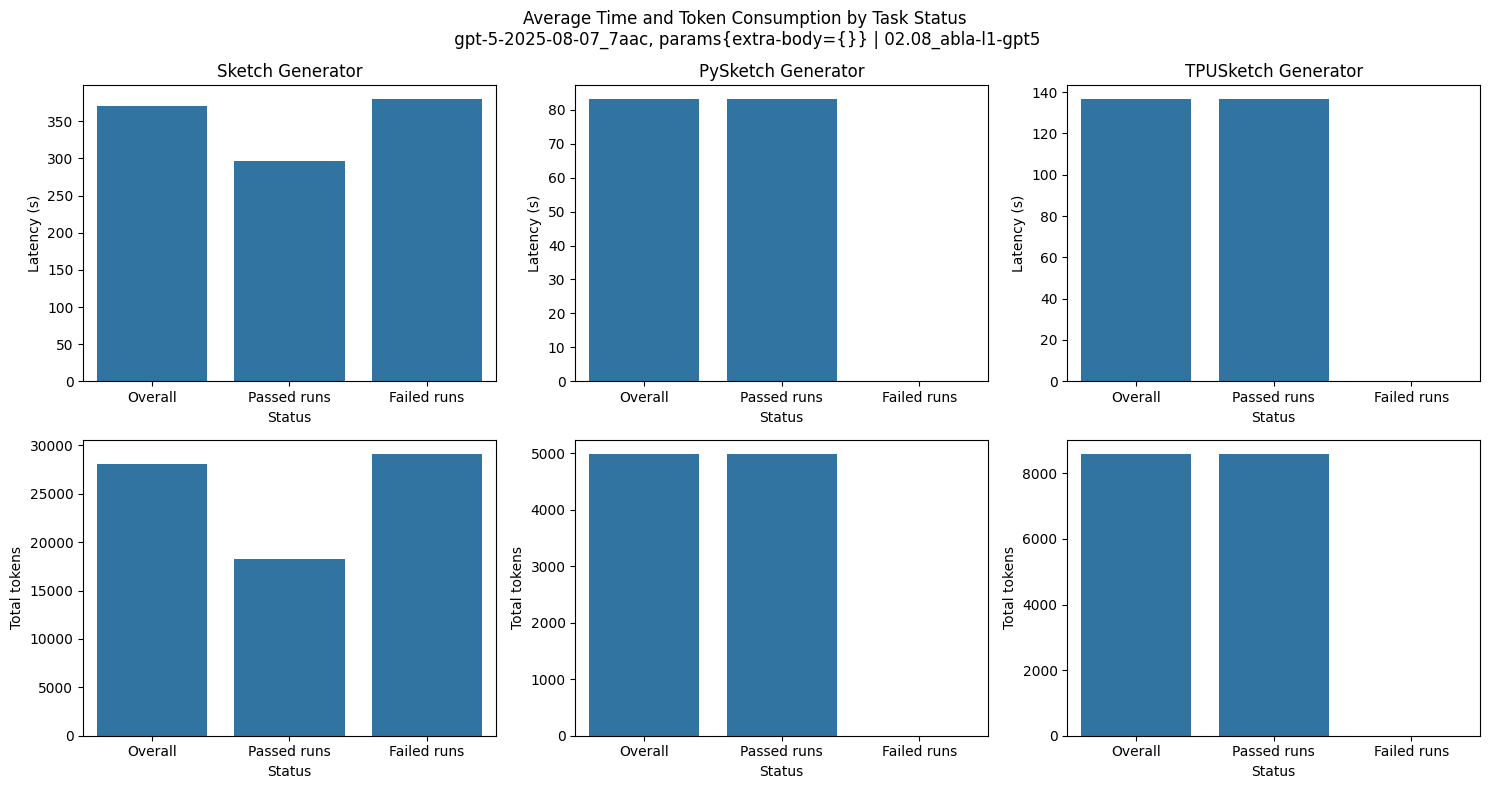

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

STATUS_LABELS = [(None, "Overall"), ("success", "Passed runs"), ("failure", "Failed runs")]
METRICS = {"latency": "latency", "total_tokens": "total_tokens"}


def prepare_data_for_plot(df, task_name):
    data = []
    for status, label in STATUS_LABELS:
        subset = df if status is None else df[df["status"] == status]
        for metric in METRICS:
            stats = series_stats(subset[metric], stats=("mean", "min", "max"))
            if "token" in metric:
                stats = {k: 0 if pd.isna(v) else int(v) for k, v in stats.items()}
            data.append(
                {
                    "Task": task_name,
                    "Metric": metric,
                    "Status": label,
                    "Average": stats["mean"],
                    "Minimum": stats["min"],
                    "Maximum": stats["max"],
                }
            )
    return pd.DataFrame(data)



for combined_df, batch_info, model_name, model_params, batch_id, batch_uid in iter_batches():
    task_frames = {}
    for processor_type in combined_df["processor_type"].unique():
        task_df = combined_df[combined_df["processor_type"] == processor_type]
        sample_batch_id = task_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        task_frames[full_name] = prepare_data_for_plot(task_df, full_name)
    df_all = pd.concat(task_frames.values())

    tasks = sorted(df_all["Task"].unique(), key=lambda x: STAGE_ORDER.index(x))
    fig, axes = plt.subplots(2, len(tasks), figsize=(5 * len(tasks), 8))
    if len(tasks) == 1:
        axes = axes.reshape(2, 1)

    for col, task in enumerate(tasks):
        task_data = df_all[df_all["Task"] == task]

        latency_ax = axes[0, col]
        latency_data = task_data[task_data["Metric"] == "latency"]
        sns.barplot(x="Status", y="Average", data=latency_data, ax=latency_ax)
        latency_ax.set_ylabel("Latency (s)")
        latency_ax.set_title(task)

        tokens_ax = axes[1, col]
        tokens_data = task_data[task_data["Metric"] == "total_tokens"]
        sns.barplot(x="Status", y="Average", data=tokens_data, ax=tokens_ax)
        tokens_ax.set_ylabel("Total tokens")

    fig.suptitle(
        f"Average Time and Token Consumption by Task Status\n {model_name}_{batch_uid}, params{{{model_params}}} | {parent_dir.split('/2026/')[1]}",
        fontsize=12,
    )
    plt.tight_layout()
    plt.savefig(
        os.path.join(save_dir, f"bar_plot_{model_name}_{date_in_filename}_{batch_uid}.pdf"),
        format="pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

## 7. Scatter plot: time, token; success, error


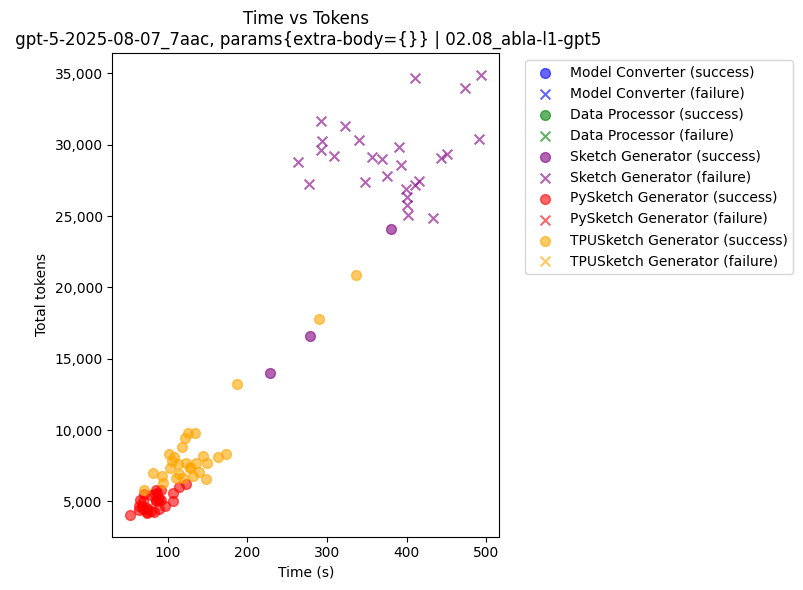

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

for combined_df, batch_info, model_name, model_params, batch_id, batch_uid in iter_batches():
    plt.figure(figsize=(8, 6))
    for task_name, color in TASK_COLORS.items():
        task_data = combined_df[
            combined_df["batch_id"].apply(lambda x: batch_info[x]["full_name"] == task_name)
        ]
        success = task_data[task_data["status"] == "success"]
        failed = task_data[task_data["status"] == "failure"]
        plt.scatter(success["latency"], success["total_tokens"], color=color, alpha=0.6, label=f"{task_name} (success)", marker="o", s=50)
        plt.scatter(failed["latency"], failed["total_tokens"], color=color, alpha=0.6, label=f"{task_name} (failure)", marker="x", s=50)

    plt.xlabel("Time (s)")
    plt.ylabel("Total tokens")
    plt.title(f"Time vs Tokens\n {model_name}_{batch_uid}, params{{{model_params}}} | {parent_dir.split('/2026/')[1]}")
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(
        os.path.join(save_dir, f"scatter_plot_{model_name}_{date_in_filename}_{batch_uid}.pdf"),
        format="pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()